In [29]:
#@title Setup the Data (RUN ME)

# Which dataset to download?
dataset = 'magazines' # @param ["restaurant", "magazines"]

# Start with a clean slate
# !rm -rf *
# !wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py

# Import everything, including homework code
import numpy as np                                              # numpy array
import pandas as pd                                             # data science
import matplotlib.pyplot as plt                                 # matplotlib
import seaborn as sns                                           # plot style
from sklearn.metrics import confusion_matrix                    # confusion matrix
from sklearn.feature_extraction.text import CountVectorizer     # bag of words
from sklearn.model_selection import train_test_split            # train/test split
from sklearn.preprocessing import MinMaxScaler                  # scale data with min/max
from tqdm import tqdm_notebook as tqdm                          # download data utility
import json                                                     # amazon data in json
from IPython.display import clear_output
import cs6220hw5                                                # import cs6220

if dataset == 'restaurant':
  !wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv

  # Read the CSV data
  data = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

else:
  # Download from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
  !wget -nc https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Magazine_Subscriptions.json.gz
  !gunzip Magazine_Subscriptions.json.gz

  # Load data in
  reviews = []
  with open('Magazine_Subscriptions.json', 'r') as f:
      for l in tqdm(f):
          r = json.loads(l)
          reviews.append(r)

  # Format the data into Pandas DataFrame
  data = pd.DataFrame.from_records(reviews)[['reviewText', 'overall']]
  print("Initial data size: ", data.size)
  data = data[ data['overall'] != 3.0]
  data = data.rename(columns={"reviewText": "Review"})
  data['Liked'] = 0
  data.loc[data['overall'] > 3, 'Liked'] = 1
  data = data.dropna()

clear_output()
print("Data matrix has shape: ", data.shape)
data.head(10)

Data matrix has shape:  (82687, 3)


,Review,overall,Liked
0,"for computer enthusiast, MaxPC is a welcome si...",5.0,1
1,Thank god this is not a Ziff Davis publication...,5.0,1
3,This beautiful magazine is in itself a work of...,5.0,1
4,A great read every issue.,5.0,1
6,I've read Maximum PC (MPC) for many years. The...,5.0,1
7,We ordered this magazine for our grandson (the...,5.0,1
8,I have subscribed to the nook version for a fe...,4.0,1
9,"I'm old, and so is my computer. Any advice th...",4.0,1
10,"At one time, this was my least favorite comput...",5.0,1
11,I didn't receive a full year. I only receive ...,2.0,0


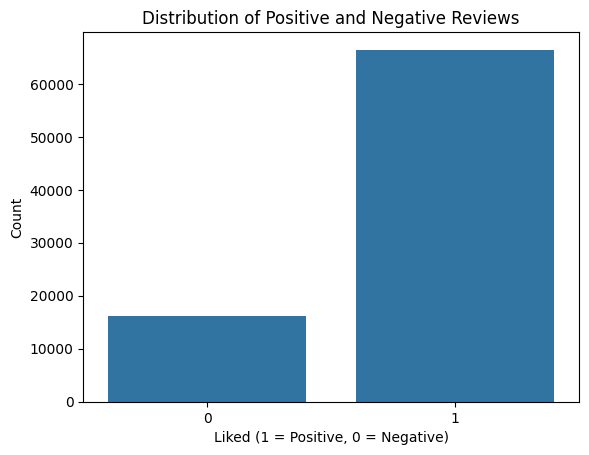

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Liked', data=data)
plt.title("Distribution of Positive and Negative Reviews")
plt.xlabel("Liked (1 = Positive, 0 = Negative)")
plt.ylabel("Count")
plt.show()


In [31]:
from imblearn.under_sampling import RandomUnderSampler

X = data['Review']
y = data['Liked']

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X)

# Balance the data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_vectorized, y)

print("Resampled data shape:", X_resampled.shape)


Resampled data shape: (32502, 5000)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (22751, 5000)
Testing set size: (9751, 5000)


In [33]:
# Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

# Predict on training set.
y_train_pred = nb_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Training Precision: {train_precision:.3f}")
print(f"Training Recall: {train_recall:.3f}")

# Predict on testing set.
y_pred_nb = nb_model.predict(X_test)

print("Testing Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Testing Naive Bayes Precision:", precision_score(y_test, y_pred_nb))
print("Testing Naive Bayes Recall:", recall_score(y_test, y_pred_nb))


Training Accuracy: 0.890
Training Precision: 0.892
Training Recall: 0.887
Testing Naive Bayes Accuracy: 0.8805250743513485
Testing Naive Bayes Precision: 0.8805474906677727
Testing Naive Bayes Recall: 0.8781799379524302


In [37]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, y_train)

# Predict on training set.
y_train_pred = dt_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Training Precision: {train_precision:.3f}")
print(f"Training Recall: {train_recall:.3f}")

# Predict on testing set.
y_pred_dt = dt_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

print("Decision Tree Performance:")
print(f"Testing Accuracy: {accuracy_dt:.2f}")
print(f"Testing Precision: {precision_dt:.2f}")
print(f"Testing Recall: {recall_dt:.2f}")

# import seaborn as sns
# import matplotlib.pyplot as plt

# conf_matrix = confusion_matrix(y_test, y_pred_dt)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Decision Tree')
# plt.show()

Training Accuracy: 0.998
Training Precision: 0.996
Training Recall: 0.999
Decision Tree Performance:
Testing Accuracy: 0.79
Testing Precision: 0.79
Testing Recall: 0.79


In [36]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)

# Predict on training set.
y_train_pred = rf_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Training Precision: {train_precision:.3f}")
print(f"Training Recall: {train_recall:.3f}")

# Predict on testing set.
y_pred_rf = rf_model.predict(X_test)

print("Testing Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Testing Precision:", precision_score(y_test, y_pred_rf))
print("Testing Recall:", recall_score(y_test, y_pred_rf))

Training Accuracy: 0.998
Training Precision: 0.996
Training Recall: 0.999
Testing Accuracy: 0.8708850374320583
Testing Precision: 0.9144645340751043
Testing Recall: 0.8159255429162358


In [38]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = LogisticRegression(max_iter=200)

model.fit(X_train, y_train)

# Predict on training set.
y_train_pred = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Training Precision: {train_precision:.3f}")
print(f"Training Recall: {train_recall:.3f}")

# Predict on testing set.
y_pred = model.predict(X_test)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("Testing Precision:", precision_score(y_test, y_pred))
print("Testing Recall:", recall_score(y_test, y_pred))

Training Accuracy: 0.946
Training Precision: 0.944
Training Recall: 0.949
Testing Accuracy: 0.8962157727412573
Testing Precision: 0.890181669728516
Testing Recall: 0.9019648397104447


# New Section